# Two Dimentional Vision System Examples

In [34]:
import numpy as np
from pyESN import ESN
from matplotlib import pyplot as plt
%matplotlib inline
import csv
import networkx as nx
import networkx as nx
from matplotlib import pyplot, patches

from utils import *

In [35]:
G = generate_ffbo_graph()

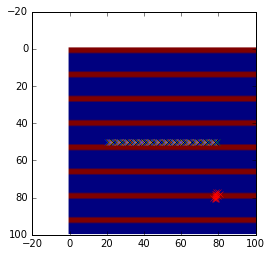

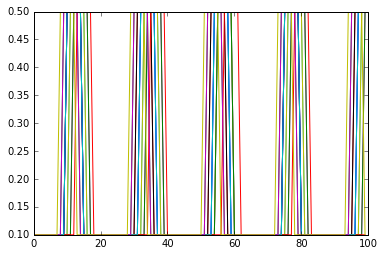

In [36]:
def bars_signal(n=100,on_size=10,off_size=10,on_val=1,off_val=0):
    image = np.zeros((n,n))
    
    i = 0
    while i < n:
        image[i:i+on_size] = on_val
        i = i+on_size
        image[i:i+off_size] = off_val
        i = i+off_size
    
    return image

def single_trial(image, centers,input_class,hex_radius =0.1):

    input_data = []
    input_class = np.array([input_class for _ in centers])
    
    for m in centers:
        ps,d,names = extract_data(image,(2,2),m, hex_radius)
        input_data.append(d)

    return np.array(input_data), input_class, ps, names



#image = bars_signal(n=100)
image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)


def generate_centers(trial_length = 100,path_start = 0.2,path_end = 0.8):
    path_steps = (path_end-path_start)/trial_length
    centers = [(n,0.5) for n in np.arange(path_start,path_end,path_steps)]
    return centers


trial_length = 100
centers = generate_centers(trial_length)

data, classes, ps, names = single_trial(image, centers,input_class=0,hex_radius =0.01)

plt.imshow(image)
for c in centers:
    plt.plot(c[0]*100,c[1]*100,'x')
plt.plot(ps[0,:],ps[1,:],'x')
plt.show()
for d in data.T:
    plt.plot(d)
plt.show()

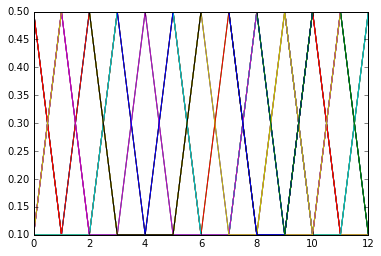

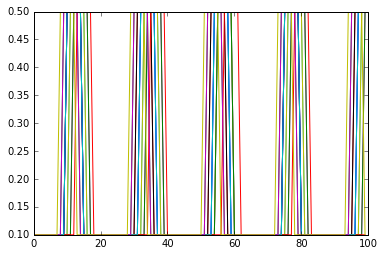

In [37]:
for i,_ in enumerate(centers):
    plt.plot(data[i,:])
plt.show()

for i in np.arange(13):
    plt.plot(data[:,i])
plt.show()


In [65]:
#image = bars_signal(n=100,on_size=10,off_size=30,on_val = 0.5,off_val = 0.1)
image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)

trial_length = 100
centers = generate_centers(trial_length)

n_outputs = 2
trials = [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]
#trials = [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]#

from random import shuffle

#shuffle(trials)

trial_data = []
trial_class = []

for trial in trials:
    cs = centers
    if trial == 0 : 
        cs.reverse()
        
    data, classes, ps, names = single_trial(image, cs,input_class=trial,hex_radius =0.1)
    
    trial_data.append(data)
    trial_class.append(classes)


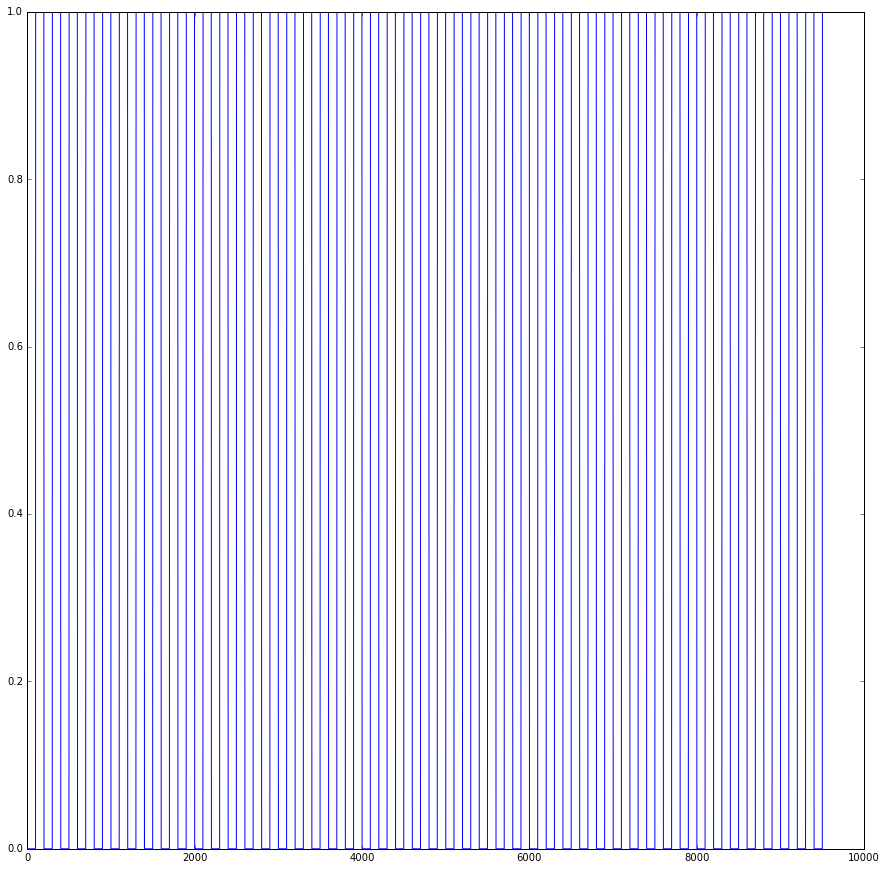

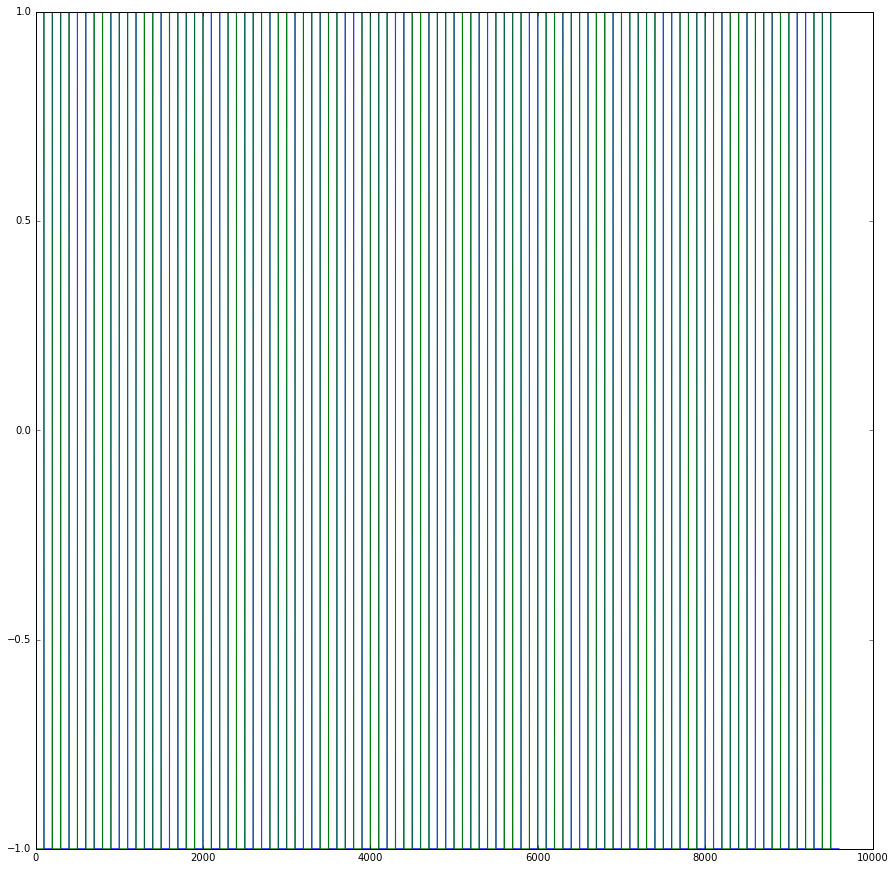

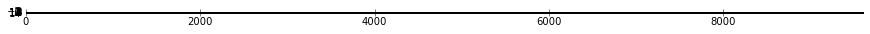

In [66]:
experiment_classes = np.hstack(trial_class)

experiment_targets= -np.ones((n_outputs,experiment_classes.shape[0]))
for i,c in enumerate(experiment_classes):
    experiment_targets[c,i] = 1

experiment_data = np.ones((trial_data[0].shape[0]*len(trial_data),trial_data[0].shape[1]))

for i,d in enumerate(trial_data):
    experiment_data[i*trial_data[0].shape[0]:(i+1)*trial_data[0].shape[0],:] = d

experiment_data = experiment_data.T




plt.plot(experiment_classes.T); 
plt.show()

plt.plot(experiment_targets[0,:]);
plt.plot(experiment_targets[1,:]);
plt.show()

plt.imshow(experiment_data); plt.show()


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Using Matrix
Using Input Matrix
state shape [9600, 434]
state shape after [9600, 434]


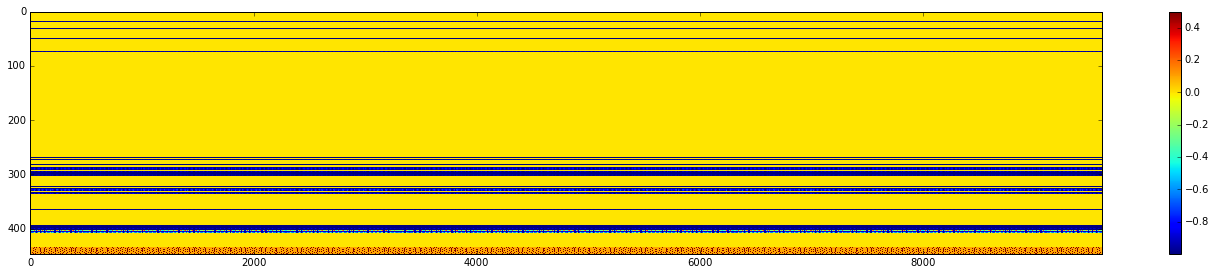

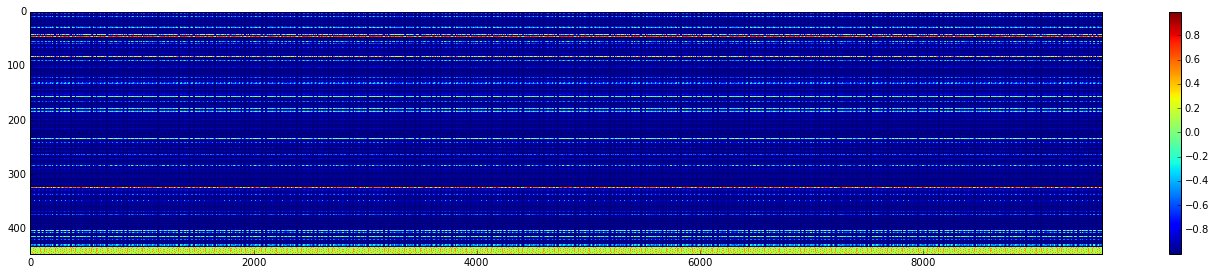

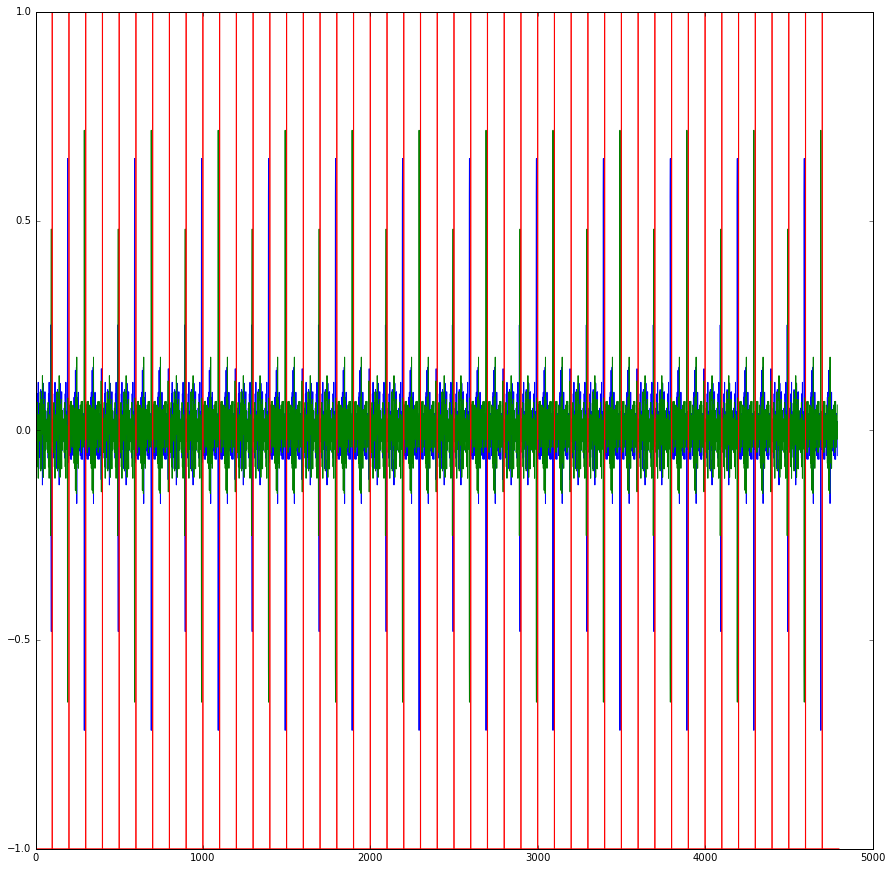

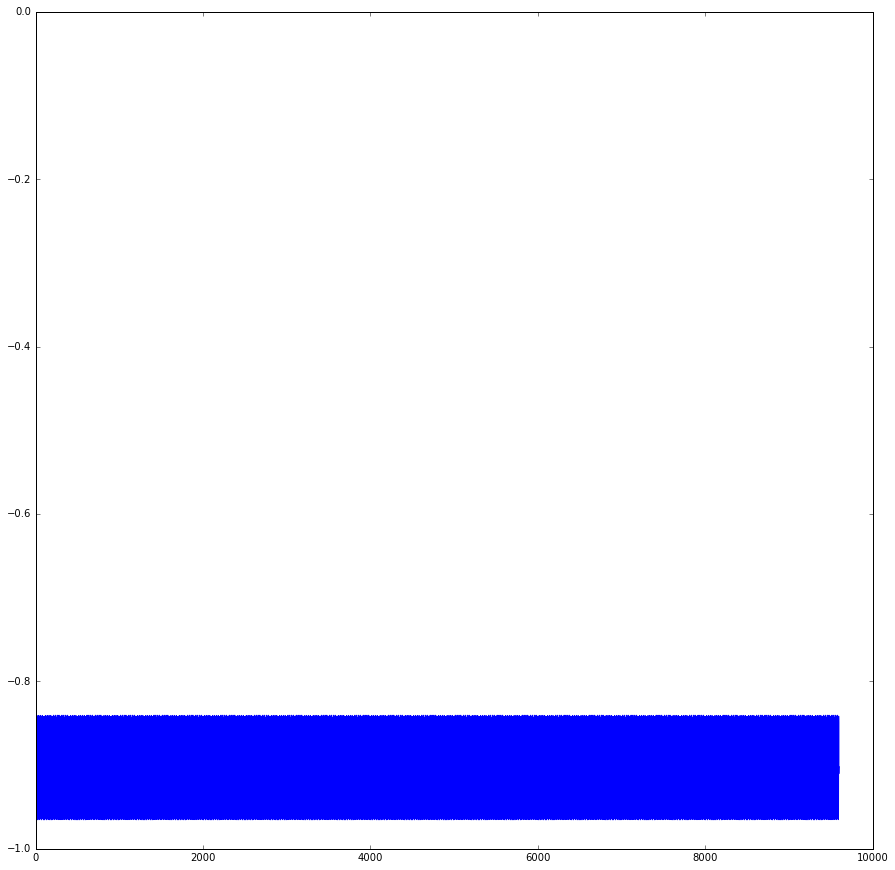

In [69]:
trainlen = experiment_targets.shape[1]/2
future =  experiment_targets.shape[1]/2
full = trainlen + future

# Simulation Data
n_reservoir =G.number_of_nodes()
n_inputs =len(names)

matrix = nx.adjacency_matrix(G, weight='weight').todense()

# Create Input Matrix
input_matrix = np.zeros((n_reservoir, n_inputs))
for j,c in enumerate(names):
    for i,n in enumerate(G.nodes()):
        if 'L1' in n or  'L2' in n or  'L4' in n:
            if c in n:
                input_matrix[i,j] = 1
                
  
print input_matrix
                
"""
esn = ESN(n_inputs = n_inputs,
          n_outputs = 2,
          n_reservoir = n_reservoir,
          spectral_radius = 1.5,
          noise = 0.01,
          random_state=42,
          teacher_forcing=False,
          matrix=matrix,
          input_matrix = input_matrix)
"""   
esn = ESN(n_inputs = n_inputs,
          n_outputs = 2,
          n_reservoir = n_reservoir,
          spectral_radius = 1.5,
          noise = 0.000,
          random_state=42,
          teacher_forcing=False,
          matrix=matrix.T,
          input_matrix = input_matrix
          )



#Create a list of network outputs that can be used to train upon
# We focus oon the T4 and Tm* neurons
o_nodes = np.zeros((input_matrix.shape[1],input_matrix.shape[0]))



for i,n in enumerate(G.nodes()):
    if 'Tm3' in n or 'Mi1' in n or 'Mi9' in n or 'Mi4' in n:    
        o_nodes[:,i] = 1
        

o_nodes = o_nodes[0,:].T
#o_nodes = None

# Fit the network        
pred_training = esn.fit(experiment_data[:trainlen].T,experiment_targets[:trainlen].T,True,o_nodes)

# Generate Output
prediction = esn.predict(experiment_data[:,trainlen:trainlen+future].T)

plt.show()
plt.plot(prediction[10:])
plt.plot(experiment_targets[:,trainlen:trainlen+future].T,'r')
plt.show()


plt.plot(np.mean(esn.full_states,axis=1));
plt.show()

Populating the interactive namespace from numpy and matplotlib


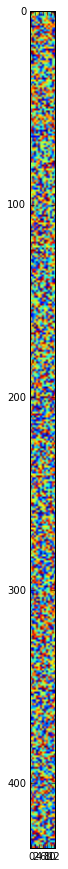

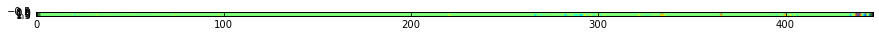

In [68]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)
#plt.imshow(esn.W); plt.show()

plt.imshow(esn.W_in); plt.show()

plt.imshow(esn.W_out); plt.show()


In [70]:
prediction_classes = np.array(trials[-(len(trials)/2):])
prediction_classes = prediction_classes[2:]

classes = [0,1]

results = {c:{o: [] for o in classes} for c in classes }

for i,c in enumerate(prediction_classes):
    tc = c

    data = prediction[i*trial_length:(i*trial_length)+trial_length,:]

    for cl in classes:
        results[tc][cl].append(sum(data[:,cl]))
  
    

In [71]:
def analise_results(results):
    for c in results:
        target = results[c][c]
        others = set(results[c].keys())
        others.remove(c)
        
        other_data = np.vstack([results[c][d] for d in others])
        
        ratio =  sum(target > np.max(other_data)) / (len(target)*1.0)
    return ratio
ratio = analise_results(results)

In [72]:
ratio

0.4782608695652174

In [73]:
results[c]

{0: [0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943,
  -1.4681515731352928,
  0.030933483658452943],
 1: [-0.030933483658452943,
  1.4681515731352928,
  -0.030933483658452943,
  1.4681515731352928,
  -0.030933483658452943,
  1.4681515731352928,
  -0.030933483658452943,
  1.4681515731352928,
  -0.030933483658452943,
  1.4681515731352928,
  -0.030933483658452943,
  1.4681515731352928,
  -0.030933483658452943,
  1.4681515731352928,
  -0.030933483658452943,
  1.4681515731352928,
  -0.030933483658452943,
  1.4681515731352928,
  -0.030933483658452943,
  1.

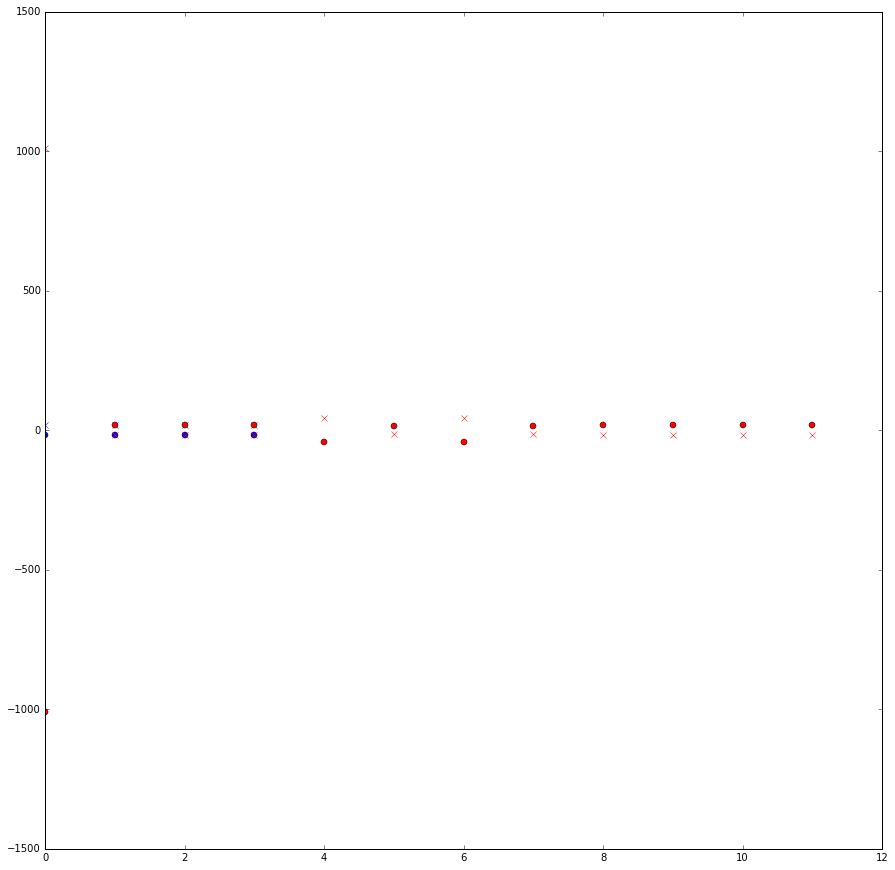

In [54]:
plt.plot(results[0][0],'bo')
plt.plot(results[0][1],'bx')

plt.plot(results[1][0],'rx')
plt.plot(results[1][1],'ro')

